In [ ]:
!pip install datasets tqdm pandas matplotlib langchain sentence_transformers faiss-gpu langchain-community torch accelerate fastapi pyngrok

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import pandas as pd
from tqdm.notebook import tqdm
from datasets import Dataset
import matplotlib.pyplot as plt
from langchain.docstore.document import Document as LangchainDocument
pd.set_option("display.max_colwidth", None)
fp = open("/content/Registration_info_dataset.txt", "r")
s = fp.read().split("\n\n\n\n")
fp.close()

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc)
    for doc in tqdm(s)
]

  0%|          | 0/145 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

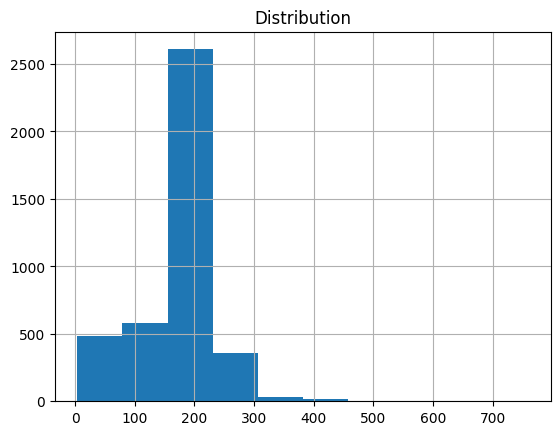

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
MARKDOWN_SEPARATORS = [
    "\n#{1,6}",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n__+\n",
    "\n\n",
    "\n",
    " ",
    ""
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    add_start_index=True,
    strip_whitespace=True,
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

fig = pd.Series(lengths).hist()
fig.set_title("Histogram of Document Lengths")
plt.title("Distribution")
plt.show()


In [ ]:
from typing import Optional, List
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer
EMBEDDING_MODEL_NAME = "thenlper/gte-small"
def split_documents(
        chunk_size: int,
        knowledge_base: list[LangchainDocument],
        tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> list[LangchainDocument]:
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )
    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)
    return docs_processed_unique

docs_processed = split_documents(512, RAW_KNOWLEDGE_BASE, tokenizer_name=EMBEDDING_MODEL_NAME)
print(len(docs_processed))
print(docs_processed[0:3])

2069
[Document(metadata={'start_index': 0}, page_content='Question: Q1. HOW IS OWNERSHIP OF IMMOVABLE PROPERTY ACQUIRED?\nAnswer: Ans:-A person may acquire immovable property in any of the following ways:Download SVGPerfect for when you want to use just one icon as a vector on the desktop or in your own icon workflow.By inheritance of ancestral property.Through will.By way of purchase etc.Through gift, trust, settlement deeds.Through Grant, sanad / Inam by the Government.Through partition deed.Through decree of Court.There are two ways of acquisition:By act of parties.Example:Purchase, gift etc.By operation of law.Example:Inheritance, decree of Court etc. (for details please see Transfer of Property Act, 1882 (Central Act))\n\nQuestion: Q2. IS IT NECESSARY TO GET DOCUMENT REGISTERED IN THE OFFICE OF SUB- REGISTRAR FOR PATTA/KHATA TRANSFER (MUTATION) IN       RESPECT OF PROPERTY ACQUIRED BY INHERITANCE?\nAnswer: Ans:-Not necessary. After the death of owner of a property his legal heirs,

In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import torch
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed,
    embedding_model,
    distance_strategy=DistanceStrategy.COSINE,
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

torch.random.manual_seed(0)

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-128k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-128k-instruct")

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

config.json:   0%|          | 0.00/3.48k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
prompt_chat = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
Give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the Question you need to answer.
Question:{question}""",
    },
]

RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_chat, tokenize=False, add_generation_prompt=True,
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
Give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer<|end|>
<|user|>
Context:
{context}
---
Now here is the Question you need to answer.
Question:{question}<|end|>
<|assistant|>



In [ ]:
# # give the match summary between punjab kings  and  chennai super kings on
# u_query = "What are the major conditions for hindu marriage?"
# # ret_text = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=u_query,k=3)
# retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=u_query,k=3)

# context = retrieved_docs[0].page_content
# final_prompt = RAG_PROMPT_TEMPLATE.format(
#     question= u_query, context = context
# )

# output = pipe(final_prompt, **generation_args)
# print("YOUR QUESTION:\n",u_query,"\n")
# print("MICROSOFT 128K ANSWER: \n",output[0]['generated_text'])

In [ ]:
u_query = "who is prime minister of pakistan?"

retrieved_docs_with_scores = KNOWLEDGE_VECTOR_DATABASE.similarity_search_with_score(query=u_query, k=3)
print("======================================\n")
for i in retrieved_docs_with_scores:
    print(i)
    print()
print("======================================\n")

retrieved_docs = [doc for doc, score in retrieved_docs_with_scores]
similarity_scores = [score for doc, score in retrieved_docs_with_scores]

print("\nSimilarity scores of the retrieved documents:", similarity_scores)
threshold_lower = 0.155
threshold_upper = 0.349

score_within_range = any(threshold_lower <= score <= threshold_upper for score in similarity_scores)

if score_within_range:
    context = retrieved_docs[0].page_content
    final_prompt = RAG_PROMPT_TEMPLATE.format(
        question=u_query, context=context
    )
    output = pipe(final_prompt, max_new_tokens=500, return_full_text=False, temperature=0.0, do_sample=False)
    print("\nAnswer found within the specified score range:")
    print("YOUR QUESTION:\n", u_query, "\n")
    print("MICROSOFT 128K ANSWER:\n", output[0]['generated_text'])
else:
    print("\nYour question is not found in the dataset.")

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:540: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.



(Document(metadata={'start_index': 28378}, page_content='Question: Content from https://registration.telangana.gov.in/resources/downloads/RTI_ACT.pdf - Page 9\nAnswer: (ii) the Leader of Opposition in the LokSabha; and  \n    (iii) a Union Cabinet Minister to be nominated by the Prime Minister.  \n      Explanation. —For the purposes of removal of doubts, it is hereby declared that \nwhere the Leader of Opposition in the House of the People has not been recognised \nas such, the Leader of the single largest group in opposition of the Government in \nthe House  of the People shall be deemed to be the Leader of Opposition.  \n  (4)    The general superintendence, direction and management of the affairs of the \nCentral Information Commission shall vest in the Chief Information Commissioner \nwho shall be assisted by th e Information Commissioners and may exercise all such \npowers and do all such acts and things which may be exercised or done by the \nCentral Information Commission auto


Answer found within the specified score range:
YOUR QUESTION:
 who is prime minister of pakistan? 

MICROSOFT 128K ANSWER:
  The Prime Minister of Pakistan is not mentioned in the provided context.


In [ ]:
!ngrok config add-authtoken 2jMbte5iMCQMxoIm5ycxjBopWWW_47SNzqkNZTwpFfVc2V43H

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!pip install uvicorn
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
from pyngrok import ngrok
import uvicorn
import nest_asyncio

# Initialize FastAPI app
app = FastAPI()

# Set up CORS middleware to allow all origins for development purposes
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # Allows all origins
    allow_credentials=True,
    allow_methods=["*"],  # Allows all methods
    allow_headers=["*"],  # Allows all headers
)

class QueryModel(BaseModel):
    query: str

# Define constants for the similarity score thresholds
THRESHOLD_LOWER = 0.112
THRESHOLD_UPPER = 0.349

@app.post("/query")
async def query_api(request: QueryModel):
    u_query = request.query

    # Retrieve documents with their similarity scores
    retrieved_docs_with_scores = KNOWLEDGE_VECTOR_DATABASE.similarity_search_with_score(query=u_query, k=3)

    # Extract documents and their scores
    retrieved_docs = [doc for doc, score in retrieved_docs_with_scores]
    similarity_scores = [score for doc, score in retrieved_docs_with_scores]

    # Check if any score is within the specified range
    score_within_range = any(THRESHOLD_LOWER <= score <= THRESHOLD_UPPER for score in similarity_scores)

    if score_within_range:
        context = retrieved_docs[0].page_content
        final_prompt = RAG_PROMPT_TEMPLATE.format(
            question=u_query, context=context
        )
        output = pipe(final_prompt, max_new_tokens=500, return_full_text=False, temperature=0.0, do_sample=False)
        return {"question": u_query, "answer": output[0]['generated_text']}
    else:
        return {"question": u_query, "answer": "Your question is not found in the dataset."}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 491.6 kB/s eta 0:00:00


In [ ]:
!pkill -f ngrok # Kill all ngrok processes

# Now try to connect again
import nest_asyncio
from pyngrok import ngrok
import uvicorn

if __name__ == "__main__":
    # Allow nest_asyncio to enable running the server in a notebook environment
    nest_asyncio.apply()
    # Set the authentication token directly (replace with your actual token)
    ngrok.set_auth_token("2jMbte5iMCQMxoIm5ycxjBopWWW_47SNzqkNZTwpFfVc2V43H")
    public_url = ngrok.connect(8000)  # Connect to port 8000
    print("ngrok tunnel 'public_url':", public_url.public_url)
    # Run the app with uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)



INFO:     Started server process [1968]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


ngrok tunnel 'public_url': https://4ba2-35-233-230-153.ngrok-free.app
INFO:     2409:408c:4e9e:4bfc:6993:ca71:db74:18aa:0 - "OPTIONS /query HTTP/1.1" 200 OK
INFO:     2409:408c:4e9e:4bfc:6993:ca71:db74:18aa:0 - "POST /query HTTP/1.1" 200 OK
INFO:     2409:408c:4e9e:4bfc:6993:ca71:db74:18aa:0 - "POST /query HTTP/1.1" 200 OK
